In [1]:
# https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch

# download cfar dataset and get it into a dataloader - DONE!
# write a CNN and get it running to good effect - DONE! but needs to be trained longer and maybe have learning rate adjusted
# learn backward and forward hooks and demo their use
# show pretty pictures of cifar dataset at the function maps and kernels

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
# download data: https://www.kaggle.com/datasets/fedesoriano/cifar10-python-in-csv?resource=download
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        adict = pickle.load(fo, encoding='bytes')
    return adict

In [4]:
data_dir = "/Users/samra/Projects/ml_demos/data/cifar-10-batches-py"
train_batch = f"{data_dir}/data_batch_1"
train_batch = unpickle(train_batch)
train_batch.keys()


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [5]:
r = unpickle(f"{data_dir}/batches.meta")
print(f"keys: {r.keys()}")
print(f"lables: {r[b'label_names']}")

keys: dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
lables: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [6]:
labels = train_batch[b'labels']
data = train_batch[b'data']

**data** -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

**labels** -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [7]:
def display_img(batch, idx):
    im = train_batch[b'data'][idx]
    lbl = train_batch[b'labels'][idx]
    print(f"lbl: {lbl}")
    im_r = im[0:1024].reshape(32, 32) # 1024 bc 32*32
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)
    img = np.dstack((im_r, im_g, im_b))
    plt.imshow(img, interpolation="nearest")
    plt.show()
    plt.close("all")

lbl: 4


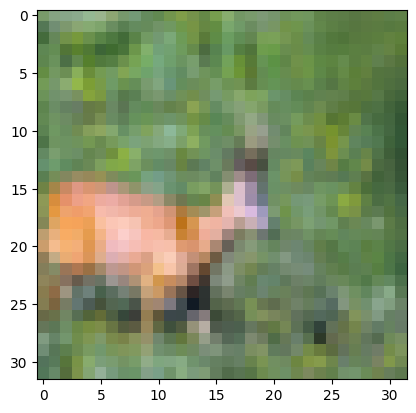

In [8]:
display_img(train_batch, 82)

In [9]:
def one_hot_vectorize(arr):
    v = np.zeros((arr.size, arr.max() + 1))
    v[np.arange(arr.size), arr] = 1
    return v

In [10]:
def get_mean_stdev(data):
    data = data / 255
    r_mean = data[:, :1024].mean()
    g_mean = data[:, 1024:2048].mean()
    b_mean = data[:, 2048:].mean()
    r_stdev = data[:, :1024].std()
    g_stdev = data[:, 1024:2048].std()
    b_stdev = data[:, 2048:].std() 
    return {
        "r_mean" : r_mean,
        "g_mean": g_mean,
        "b_mean": b_mean,
        "r_stdev": r_stdev,
        "g_stdev": g_stdev,
        "b_stdev": b_stdev
    }
mst = get_mean_stdev(data)
mst

{'r_mean': 0.4934578442861525,
 'g_mean': 0.4833751616115195,
 'b_mean': 0.4471791639859068,
 'r_stdev': 0.2476211676841856,
 'g_stdev': 0.244585121463057,
 'b_stdev': 0.26261100055409053}

In [11]:
def load_data_from_disk(is_train):
    if is_train:
        data = []
        labels = []
        for i in range(1, 6):
            f = f"{data_dir}/data_batch_{i}"
            batch = unpickle(f)
            data.extend(batch[b'data'])
            labels.extend(batch[b'labels'])
        data = np.array(data)
        labels = np.array(labels)
    else:
        test_batch = f"{data_dir}/test_batch"
        test_batch = unpickle(test_batch)
        data = test_batch[b'data']
        labels = np.array(test_batch[b'labels'])
    return data, labels

def normalize_data(data, labels):
    # normalization
    data = data / 255
    data_r = (data[:, :1024] - mst["r_mean"]) / mst["r_stdev"] # r
    data_g = (data[:, 1024:2048] - mst["g_mean"]) / mst["g_stdev"] # g
    data_b = (data[:, 2048:] - mst["b_mean"]) / mst["b_stdev"] # r
    data = np.concatenate((data_r, data_g, data_b), axis=1)
    data = np.array([im.reshape(3, 32, 32) for im in data])
    labels = one_hot_vectorize(labels)
    return data, labels

In [12]:
train_data, train_labels = load_data_from_disk(is_train=True)
train_data, train_labels = normalize_data(train_data, train_labels)
test_data, test_labels = load_data_from_disk(is_train=False)
test_data, test_labels = normalize_data(test_data, test_labels)

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, imgs, lbls):
        self.imgs = torch.Tensor(imgs)
        self.img_labels = torch.Tensor(lbls)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label

In [14]:
train_ds = CustomImageDataset(train_data, train_labels)
test_ds = CustomImageDataset(test_data, test_labels)

In [15]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

## Calculating shape of CNN Conv Output
Formula for calculating output for a cnn conv layer: [(W−K+2P)/S]+1

W = Input size

K = Filter size

S = Stride

P = Padding 

Given input 3x32x32, kernel_size=5, stride=2, padding=2 

output is: [(32-5 + 2*2)/2]+1 = 16.5, but within square brackets we have a floor function so it is 16,
which makes the output of the layer batch_size x num_kernels (out_channels) x 16 x 16 or batch_size, 5, 16, 16

# Calculating shape of MaxPool2d Output
output_height = [(h_in - pool_height) / stride] + 1

output_width = [(h_in - pool_width) / stride] + 1

number of channels remains the same as input

so since our input into the first layer is 3x32x32, then:

our output_height = ((16-2) / 2) + 1 = 8

and output_width = ((16-2) / 2) + 1 = 8

resulting in an output of batch_size, 5, 8, 8


In [16]:
# Calculating second convolutional and maxpool layer
# conv2d
# (((8-3)+2*2)/2)+1 = 5 # batch_size, 2, 5, 5
# maxpool2d
# ((5-2)/2) + 1 = 2 # batch_size, 2, 2, 2
# flatten, but keep batch, means that the input to fc1 is batch_size, 2 * 2 * 2 
# so input to fc1 is batch_size, 8 and output is batch_size, 64
# input to fc2 is batch_size, 64 and output is batch_size, 10

In [33]:
import torch.nn as nn
import torch.nn.functional as F

# torch.manual_seed(666);
class Cifar10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=20, kernel_size=3, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(in_features=80, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        # print(f"conv1 out: {x.shape}")
        x = F.relu(x)
        x = self.pool1(x)
        # print(f"pool1 out: {x.shape}")
        x = self.conv2(x)
        # print(f"conv2 out: {x.shape}")
        x = F.relu(x)
        x = self.pool2(x)
        # print(f"pool2 out: {x.shape}")
        x = torch.flatten(x, start_dim=1)
        # print(f"ravel: {x.shape}")
        x = self.fc1(x)
        x = F.relu(x)
        nn.Dropout(p=0.5)
        x = self.fc2(x)
        # print(f"x last: {x.shape}")
        nn.Dropout(p=0.5)
        return x   

In [34]:
# train
cnn = Cifar10CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)
cnn.train()
n_epochs = 5000
losses = []
for epoch in range(n_epochs):
    running_loss = 0.0
    num_batches = 0
    for i, (X,y) in enumerate(train_loader):
        optimizer.zero_grad()
        preds = cnn(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    mean_loss = running_loss/num_batches
    losses.append(mean_loss)
    print(f"epoch mean loss {epoch}: {mean_loss}")

epoch mean loss 0: 2.288504389563357
epoch mean loss 1: 2.225563213829802
epoch mean loss 2: 2.1363226023531845
epoch mean loss 3: 2.049996982075355
epoch mean loss 4: 1.9864612034476117
epoch mean loss 5: 1.935860901174832
epoch mean loss 6: 1.8854967404540655
epoch mean loss 7: 1.8333989413060672
epoch mean loss 8: 1.783252247159327
epoch mean loss 9: 1.7402564166679797
epoch mean loss 10: 1.7035707039323589
epoch mean loss 11: 1.671130428845045
epoch mean loss 12: 1.642145159453516
epoch mean loss 13: 1.6157869890723104
epoch mean loss 14: 1.5920601968801869
epoch mean loss 15: 1.5713017696153637
epoch mean loss 16: 1.5524330499152381
epoch mean loss 17: 1.5343794453548303
epoch mean loss 18: 1.5181855381259686
epoch mean loss 19: 1.5020507076804026
epoch mean loss 20: 1.4872651837685134
epoch mean loss 21: 1.4735013107725694
epoch mean loss 22: 1.4603364447028073
epoch mean loss 23: 1.4481369949882028
epoch mean loss 24: 1.4357795746221194
epoch mean loss 25: 1.4239459748612866
epo

KeyboardInterrupt: 

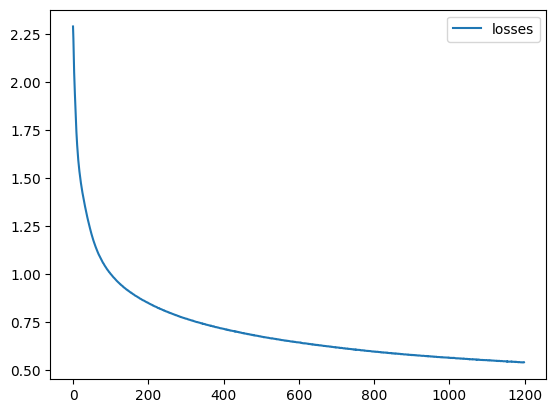

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=pd.DataFrame(losses, columns=["losses"]))
plt.show()
plt.close() 

In [36]:
# test
import numpy as np
with torch.no_grad():
    cnn.eval()
    mean_acc = None
    for i, (X, y) in enumerate(test_loader):
        preds = cnn(X)
        preds = torch.argmax(preds, dim=-1)
        y = torch.argmax(y, dim=-1)
        correct = (preds == y).sum().item()
        accuracy = correct / preds.numel()
        print(accuracy)
        mean_acc =  accuracy if mean_acc is None else np.mean([mean_acc, accuracy])
print(f"mean accuracy: {mean_acc}")
    

0.619
0.633
0.6
0.618
0.637
0.605
0.622
0.614
0.608
0.622
mean accuracy: 0.6171015625


# Visualizing 
https://github.com/utkuozbulak/pytorch-cnn-visualizations?tab=readme-ov-file

## Visualizing kernels in first layer

In [39]:
first_kernel_layers =  model.conv1.weight.detach().clone()
print(f"kernel shape: {first_kernel_layers.shape}")

kernel shape: torch.Size([50, 3, 5, 5])


In [40]:
min_fkl = first_kernel_layers.min()
max_fkl = first_kernel_layers.max()
normalized = (first_kernel_layers - min_fkl) / (max_fkl - min_fkl)
normalized.shape

torch.Size([50, 3, 5, 5])

In [41]:
normalized = torch.permute(normalized, (0,2,3,1))
normalized.shape

torch.Size([50, 5, 5, 3])

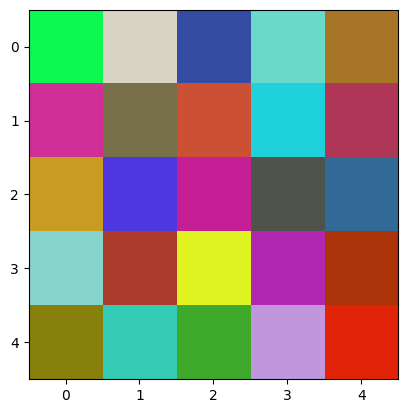

In [55]:
plt.imshow(normalized[1], cmap="viridis")

torch.Size([3, 72, 37])


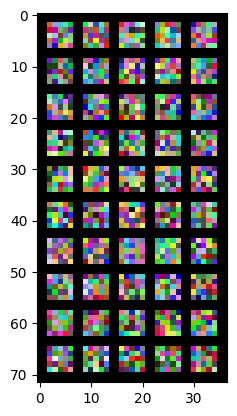

In [43]:
# https://stackoverflow.com/a/62061503/4882806
import torchvision
def plt_layer1_kernels(kernels):
    # normalize
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    filter_img = torchvision.utils.make_grid(kernels, nrow=5) # show each of items in the batch at same time
    # change ordering since matplotlib requires images to be (H, W, C)
    print(filter_img.shape)
    plt.imshow(filter_img.permute(1, 2, 0))
    plt.show()
    plt.close()
plt_layer1_kernels(first_kernel_layers)

## Visualizing feature maps (activations)

In [44]:
# https://discuss.pytorch.org/t/visualize-feature-map/29597/2

In [45]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [46]:
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

In [47]:
model.conv1.register_forward_hook(get_activation("conv1"))
model.conv2.register_forward_hook(get_activation("conv2"))

In [48]:
selected_img = 44
datum, _ = test_ds[selected_img]
datum = datum.unsqueeze(0) # add an extra dimension to make it a batch of 1
print(datum.shape)
out = model(datum)

torch.Size([1, 3, 32, 32])


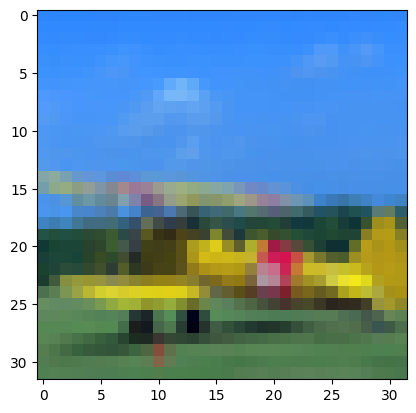

In [49]:
og_img = datum.permute(0, 2, 3, 1)
plt.imshow(normalize_output(og_img[0]))

torch.Size([16, 16])


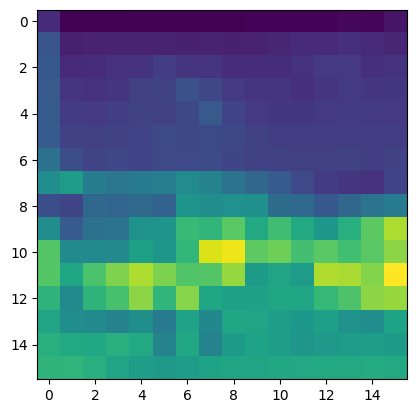

In [50]:
conv1_acts = activations["conv1"]
conv1_acts = conv1_acts[0]
conv1_acts = normalize_output(conv1_acts)
conv1_acts = conv1_acts.permute(1,2,0)
conv1_acts = torch.mean(conv1_acts, dim=-1) # average the last dimension because the shape was 5,5,2 which can't be used in imshow
print(conv1_acts.shape)
plt.imshow(conv1_acts)
plt.show()
plt.close()
# ps is on a scale from blue (least important) <---> yellow (most important)

torch.Size([5, 5])


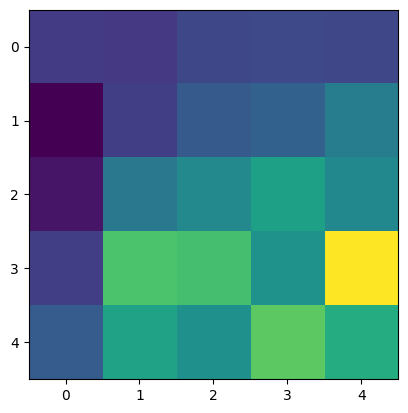

In [51]:
conv2_acts = activations["conv2"]
conv2_acts = conv2_acts[0]
conv2_acts = normalize_output(conv2_acts)
conv2_acts = conv2_acts.permute(1,2,0)
# average the last dimension because the shape was 5,5,2 which can't be used in imshow
# https://discuss.pytorch.org/t/how-can-i-solve-the-error-typeerror-invalid-shape-60-60-8-for-image-data/144839
conv2_acts = torch.mean(conv2_acts, dim=-1) 
print(conv2_acts.shape)
plt.imshow(conv2_acts)
plt.show()
plt.close()

In [52]:
print(f"conv1 activations shape: {activations['conv1'].shape}")
print(f"conv2 activations shape: {activations['conv2'].shape}")

conv1 activations shape: torch.Size([1, 50, 16, 16])
conv2 activations shape: torch.Size([1, 20, 5, 5])
